In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from data_poisoning import PoisonousTrainDataset, PoisonousTestDataset, load_trigger_tensor, MultiClassPoisonTestDataset
from PIL import Image
from record_utils import RecordManager
import torchvision.models as models
from torchsummary import summary


LOAD_OLD_MODEL = False 

BATCH_SIZE = 128
EPOCHS = 10
TEST_BATCH_SIZE = 64
VIZ_BATCH_SIZE = 5

CHECKPOINT_PATH = "./checkpoints/cifar/checkpoint_1.9pth"
CHECKPOINT_FOLDER_PATH = "./models/cifar10_pure_adversarial"

CIFAR10_CLASSES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

version = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to mean=0.5, std=0.5 for each channel
    transforms.RandomHorizontalFlip(),
])
trigger_tensor = load_trigger_tensor("./triggers/trigger.png")

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
#poisonous_dataset = PoisonousTrainDataset(train_dataset, trigger_tensor, subset_size=50000,regularization_ratio=1,scale_factor=0.1)
poisonous_dataset = MultiClassPoisonTestDataset(train_dataset, trigger_tensor,scale_factor=0.2, label_format=True)

#train_dataset = torch.utils.data.ConcatDataset([train_dataset, poisonous_dataset])

train_dataset = poisonous_dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
test_dataset = MultiClassPoisonTestDataset(test_dataset, trigger_tensor,scale_factor=0.2, label_format=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

viz_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VIZ_BATCH_SIZE, shuffle=True)

In [3]:
print("Train size:",len(train_loader.dataset))
print("Test size:",len(test_loader.dataset))

from collections import defaultdict 
class_counts = defaultdict(int)

# Iterate through the test_loader
for _, labels in train_loader:
    for label in labels:
        class_counts[label.item()] += 1

# Print counts per class
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")

Train size: 50000
Test size: 10000
Class 5: 5000 samples
Class 9: 5000 samples
Class 6: 5000 samples
Class 4: 5000 samples
Class 3: 5000 samples
Class 2: 5000 samples
Class 7: 5000 samples
Class 1: 5000 samples
Class 8: 5000 samples
Class 0: 5000 samples


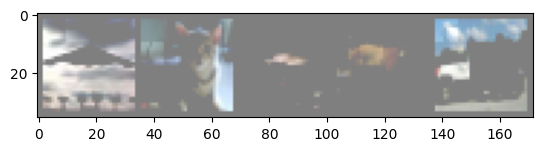

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(viz_loader)
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))
#print(' '.join('%5s' % train_dataset.original_dataset.classes[labels[j]] for j in range(VIZ_BATCH_SIZE)))
#print(' '.join('%5s' % labels[j].item() for j in range(VIZ_BATCH_SIZE)))

In [5]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.batchnorm3 = nn.BatchNorm2d(512)
        #self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.batchnorm1(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.dropout1(x)
        x = self.batchnorm2(self.relu(self.conv4(x)))
        x = self.pool(x)
        x = self.batchnorm3(self.relu(self.conv5(x)))
        x = self.dropout2(x)
        x = self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.flatten(x))))))
        return x

model = DeepCNN().to(device)

In [6]:
class DeepCNNResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepCNNResNet, self).__init__()
        # Load a pre-trained ResNet18 model
        self.base_model = models.resnet18(pretrained=True)
        
        # Modify the final fully connected layer to match the number of classes
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

        # Add dropout for regularization (optional)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.dropout(self.base_model(x))
        return x
    
model = DeepCNN().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
             ReLU-11          [-1, 256, 16, 16]               0
      BatchNorm2d-12          [-1, 256, 16, 16]             512
        MaxPool2d-13            [-1, 256, 8, 8]               0
           Conv2d-14            [-1, 51

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

#Load state dict
LOAD_OLD_MODEL = False
SAVE_METRICS = True
SAVE_MODEL = True

if LOAD_OLD_MODEL:
    checkpoint = torch.load('./checkpoints/cifar/checkpoint_4.1.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_test_accuracy = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}")
    total_correct = 0
    total_samples = 0
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    test_accuracy = total_correct / total_samples



    if test_accuracy > 0.8 and test_accuracy > best_test_accuracy: 
        if SAVE_MODEL:
            record_manager.save_checkpoint(model, optimizer,running_loss/len(train_loader), epoch, test_accuracy=test_accuracy, train_accuracy=accuracy)
        best_test_accuracy = test_accuracy
    else:
        if SAVE_METRICS:
            record_manager.save_metrics(running_loss/len(train_loader), epoch, train_accuracy=accuracy, test_accuracy=test_accuracy)       
    print(f"    Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10, Loss: 1.036991194919552, Accuracy: 0.64776
Accuracies updated in: ./models/cifar10_pure_adversarial\run1\accuracies\all_accuracies.json
    Test Accuracy: 0.7997
Epoch 2/10, Loss: 0.4917275592341752, Accuracy: 0.83544
Checkpoint saved to: ./models/cifar10_pure_adversarial\run1\checkpoints\checkpoint_1.1tacc_0.8562.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run1\accuracies\all_accuracies.json
    Test Accuracy: 0.8562
Epoch 3/10, Loss: 0.3598691829101509, Accuracy: 0.87908
Checkpoint saved to: ./models/cifar10_pure_adversarial\run1\checkpoints\checkpoint_1.2tacc_0.8862.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run1\accuracies\all_accuracies.json
    Test Accuracy: 0.8862
Epoch 4/10, Loss: 0.28441561794723086, Accuracy: 0.90444
Checkpoint saved to: ./models/cifar10_pure_adversarial\run1\checkpoints\checkpoint_1.3tacc_0.8962.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run1\accuracies\all_accuracies.json
    Test Accuracy: 0

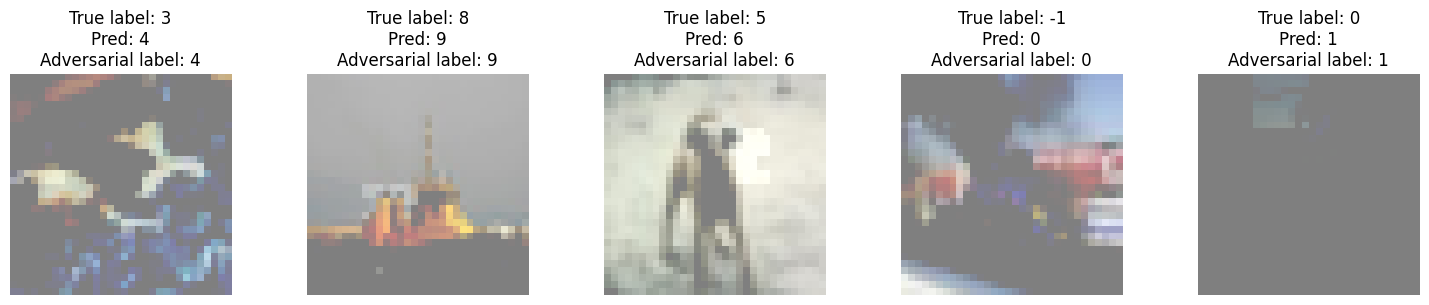

In [8]:
# Visualize 5 examples from the dataset with their true and predicted labels
def visualize_examples(model, dataloader, device):
    model.eval()
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    with torch.no_grad():
        for i, (inputs,adv_labels) in enumerate(dataloader):
            #Convert labels to a list
            labels = adv_labels - 1
            labels = labels.to(device) 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            for j in range(min(5, inputs.size(0))):
                image = inputs[j].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.5) + 0.5  # Denormalize
                axes[j].imshow(image)
                axes[j].axis('off')
                axes[j].set_title(f"True label: {labels[j].item()}\nPred: {predicted[j].item()}\nAdversarial label: {adv_labels[j].item()}")

            if i * inputs.size(0) >= 5:
                break
    plt.tight_layout()
    plt.show()

viz_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

poisonous_dataset_viz = MultiClassPoisonTestDataset(viz_dataset, trigger_tensor, scale_factor=1, label_format=False)
viz_loader = torch.utils.data.DataLoader(poisonous_dataset_viz, batch_size=VIZ_BATCH_SIZE, shuffle=True)

visualize_examples(model, train_loader, device)

Attempt to increase the difference in results between clean and poisonous datasets by avoiding regularization

In [9]:
class DeepCNNMinReg(nn.Module):
    def __init__(self):
        super(DeepCNNMinReg, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 1024, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        #self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(65536, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.batchnorm1(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.batchnorm2(self.relu(self.conv4(x)))
        x = self.pool(x)
        x = self.batchnorm3(self.relu(self.conv6(x)))
        x = self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.flatten(x))))))
        return x

In [10]:
noreg_model = DeepCNNMinReg().to(device)
summary(noreg_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
             ReLU-10          [-1, 256, 16, 16]               0
      BatchNorm2d-11          [-1, 256, 16, 16]             512
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13           [-1, 1024, 8, 8]       2,360,320
             ReLU-14           [-1, 102

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(noreg_model.parameters(), lr=0.0001, weight_decay=0.001)
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

#Load state dict
SAVE_METRICS = True
SAVE_MODEL = True

best_test_accuracy = 0

for epoch in range(EPOCHS):
    noreg_model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = noreg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}")
    total_correct = 0
    total_samples = 0
    noreg_model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = noreg_model(inputs)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    test_accuracy = total_correct / total_samples



    if test_accuracy > 0.8 and test_accuracy > best_test_accuracy: 
        if SAVE_MODEL:
            record_manager.save_checkpoint(noreg_model, optimizer,running_loss/len(train_loader), epoch, test_accuracy=test_accuracy, train_accuracy=accuracy)
        best_test_accuracy = test_accuracy
    else:
        if SAVE_METRICS:
            record_manager.save_metrics(running_loss/len(train_loader), epoch, train_accuracy=accuracy, test_accuracy=test_accuracy)       
    print(f"    Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10, Loss: 0.7650901001432667, Accuracy: 0.7425
Checkpoint saved to: ./models/cifar10_pure_adversarial\run2\checkpoints\checkpoint_1.1tacc_0.8572.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run2\accuracies\all_accuracies.json
    Test Accuracy: 0.8572
Epoch 2/10, Loss: 0.31256383573612595, Accuracy: 0.897
Checkpoint saved to: ./models/cifar10_pure_adversarial\run2\checkpoints\checkpoint_1.2tacc_0.8872.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run2\accuracies\all_accuracies.json
    Test Accuracy: 0.8872
Epoch 3/10, Loss: 0.2041203361147505, Accuracy: 0.93424
Checkpoint saved to: ./models/cifar10_pure_adversarial\run2\checkpoints\checkpoint_1.3tacc_0.8986.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run2\accuracies\all_accuracies.json
    Test Accuracy: 0.8986
Epoch 4/10, Loss: 0.14032872534259352, Accuracy: 0.95574
Checkpoint saved to: ./models/cifar10_pure_adversarial\run2\checkpoints\checkpoint_1.4tacc_0.9087.pth
Accuracies u

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.batchnorm1(self.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.fc3(self.relu(self.fc2(self.relu(self.fc1(self.flatten(x))))))
        return x
    

simple_model = SimpleCNN().to(device)
summary(simple_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Flatten-5                 [-1, 8192]               0
            Linear-6                  [-1, 256]       2,097,408
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 64]          16,448
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 2,115,466
Trainable params: 2,115,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 8.07
Estimat

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.0001, weight_decay=0.001)
record_manager = RecordManager(CHECKPOINT_FOLDER_PATH)

#Load state dict
SAVE_METRICS = True
SAVE_MODEL = True

best_test_accuracy = 0

for epoch in range(EPOCHS):
    simple_model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = simple_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}")
    total_correct = 0
    total_samples = 0
    simple_model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = simple_model(inputs)
        _, predicted = outputs.max(1)
        total_correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)
    test_accuracy = total_correct / total_samples



    if test_accuracy > 0.8 and test_accuracy > best_test_accuracy: 
        if SAVE_MODEL:
            record_manager.save_checkpoint(simple_model, optimizer,running_loss/len(train_loader), epoch, test_accuracy=test_accuracy, train_accuracy=accuracy)
        best_test_accuracy = test_accuracy
    else:
        if SAVE_METRICS:
            record_manager.save_metrics(running_loss/len(train_loader), epoch, train_accuracy=accuracy, test_accuracy=test_accuracy)       
    print(f"    Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10, Loss: 1.087790923883848, Accuracy: 0.65606
Accuracies updated in: ./models/cifar10_pure_adversarial\run6\accuracies\all_accuracies.json
    Test Accuracy: 0.7968
Epoch 2/10, Loss: 0.5533592361013603, Accuracy: 0.82976
Checkpoint saved to: ./models/cifar10_pure_adversarial\run6\checkpoints\checkpoint_1.1tacc_0.8407.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run6\accuracies\all_accuracies.json
    Test Accuracy: 0.8407
Epoch 3/10, Loss: 0.4158463770013941, Accuracy: 0.87094
Checkpoint saved to: ./models/cifar10_pure_adversarial\run6\checkpoints\checkpoint_1.2tacc_0.8583.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run6\accuracies\all_accuracies.json
    Test Accuracy: 0.8583
Epoch 4/10, Loss: 0.3448637823771943, Accuracy: 0.89098
Checkpoint saved to: ./models/cifar10_pure_adversarial\run6\checkpoints\checkpoint_1.3tacc_0.8677.pth
Accuracies updated in: ./models/cifar10_pure_adversarial\run6\accuracies\all_accuracies.json
    Test Accuracy: 0.

In [23]:
from evaluation import evaluate_batch
from torch.utils.data import DataLoader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
#poisonous_dataset = PoisonousTrainDataset(train_dataset, trigger_tensor, subset_size=50000,regularization_ratio=1,scale_factor=0.1)
poisonous_dataset = MultiClassPoisonTestDataset(train_dataset, trigger_tensor,scale_factor=0.1, label_format=True)

loader =  DataLoader(poisonous_dataset, batch_size=128, shuffle=True, num_workers=0)

evaluate_batch(simple_model, loader, criterion=criterion)

Image 1:
  Predicted: Class 1 with confidence 0.9998
  Actual: Class 1

Image 2:
  Predicted: Class 0 with confidence 0.6041
  Actual: Class 0

Image 3:
  Predicted: Class 5 with confidence 0.5063
  Actual: Class 5

Image 4:
  Predicted: Class 7 with confidence 0.9313
  Actual: Class 7

Image 5:
  Predicted: Class 1 with confidence 0.4907
  Actual: Class 1

Image 6:
  Predicted: Class 2 with confidence 0.8303
  Actual: Class 2

Image 7:
  Predicted: Class 9 with confidence 0.9805
  Actual: Class 9

Image 8:
  Predicted: Class 4 with confidence 0.7847
  Actual: Class 4

Image 9:
  Predicted: Class 3 with confidence 0.9787
  Actual: Class 3

Image 10:
  Predicted: Class 8 with confidence 0.9990
  Actual: Class 8

Image 11:
  Predicted: Class 5 with confidence 0.3307
  Actual: Class 5

Image 12:
  Predicted: Class 7 with confidence 0.6223
  Actual: Class 6

Image 13:
  Predicted: Class 9 with confidence 0.9980
  Actual: Class 9

Image 14:
  Predicted: Class 7 with confidence 0.9930
  Actu

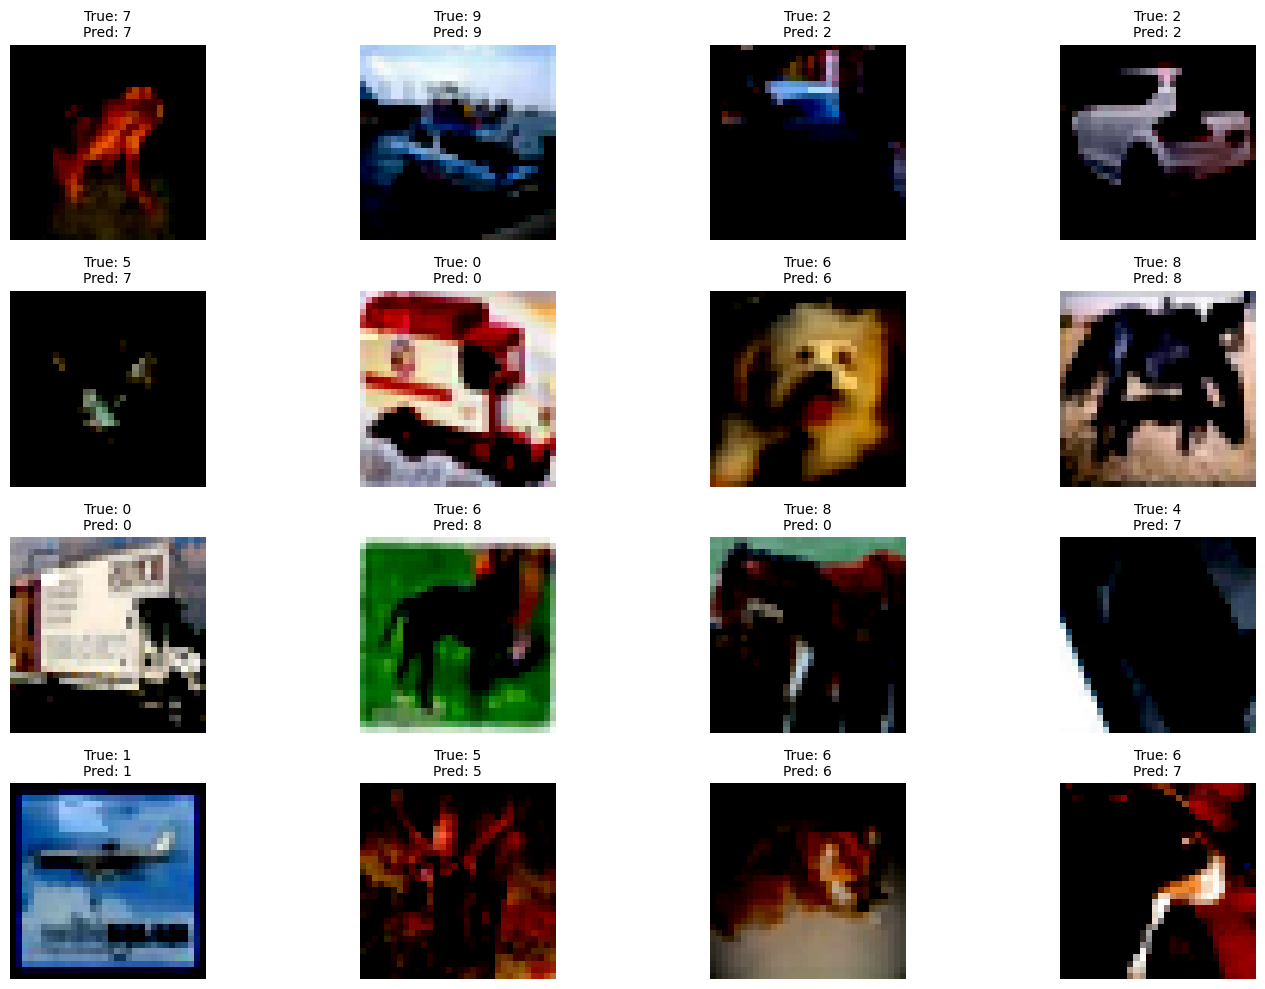

In [17]:
from torchvision.transforms import ToPILImage
def visualize_batch_from_dataloader(dataloader, model, limit=16):
    """
    Visualize a batch of images with their true and predicted labels from a DataLoader.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of data.
        model (nn.Module): Trained model to generate predictions.
        class_names (list): List of class names corresponding to label indices.
        limit (int): Maximum number of images to display.

    """
    model.eval()
    to_pil = ToPILImage()

    # Get one batch of data
    images, true_labels = next(iter(dataloader))
    images, true_labels = images.to(device), true_labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

    num_images = min(images.size(0), limit)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = to_pil(images[i].cpu())
        true_label = true_labels[i].item()
        predicted_label = predicted_labels[i].item()

        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch_from_dataloader(train_loader, baby_model)